In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
from tqdm import tqdm
import random

c:\Users\Anne-\anaconda3\envs\introML\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Den angitte prosedyren ble ikke funnet'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [3]:
# PREPROCESSING

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch_generator1 = torch.Generator().manual_seed(42)
torch_generator2 = torch.Generator().manual_seed(43)

# 1. Load the Dataset (midlertidig, for split + mean/std)

temp_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

data_dir = '../data/vehicle-type-detection'  # Assuming you run the script from the parent directory
full_dataset_temp = datasets.ImageFolder(data_dir, transform=temp_transform)

# 2. Split the Data (brukes kun til å finne indekser)

train_size = int(0.8 * len(full_dataset_temp))
val_size = len(full_dataset_temp) - train_size
train_dataset_temp, val_dataset_temp = random_split(
    full_dataset_temp,
    [train_size, val_size],
    generator=torch_generator1
)

# 3. Calculate Mean and STD on train data

TEMP_BATCH_SIZE = 64
temp_train_loader = DataLoader(train_dataset_temp, batch_size=TEMP_BATCH_SIZE, shuffle=False)

def calculate_mean_and_std(loader):
    """Calculates channel-wise mean and standard deviation from a DataLoader."""
    channels_sum, channels_sq_sum, num_batches = 0, 0, 0

    # Iterate over the dataset and accumulate sums
    for data, _ in tqdm(loader, desc="Calculating Stats"):
        # data shape is (batch_size, channels, height, width)
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_sq_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    # Final calculation
    mean = channels_sum / num_batches
    # E[(X - mu)^2] = E[X^2] - (E[X])^2
    std = torch.sqrt(channels_sq_sum / num_batches - mean**2)

    # Convert tensors to lists/tuples of floats for use in transforms.Normalize
    return mean.tolist(), std.tolist()

MEAN, STD = calculate_mean_and_std(temp_train_loader)

# 4. Define Preprocessing Pipelines

# --> TRAIN: med random augmentering
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),     # Crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# --> VAL/TEST: ingen random, kun deterministisk resize + normalize
eval_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

# Lag to "full-datasets" med ulike transforms
full_dataset_train = datasets.ImageFolder(data_dir, transform=train_transform)
full_dataset_eval  = datasets.ImageFolder(data_dir, transform=eval_transform)

# Retain the original indices from the first random_split
train_indices = train_dataset_temp.indices
val_indices   = val_dataset_temp.indices

# Create the final, fully transformed train and validation/test datasets
train_dataset   = Subset(full_dataset_train, train_indices)
val_test_dataset = Subset(full_dataset_eval,  val_indices)

# Split val_indices videre i val og test med samme generator som før
val_dataset, test_dataset = random_split(
    val_test_dataset,
    [val_size // 2, val_size - val_size // 2],
    generator=torch_generator2
)

# Check sizes to ensure split is preserved
print(f"Final Train Size: {len(train_dataset)}")
print(f"Final Validation Size: {len(val_dataset)}")
print(f"final test size: {len(test_dataset)}")

# 5. Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)


Calculating Stats: 100%|██████████| 17/17 [00:03<00:00,  5.54it/s]

Final Train Size: 1048
Final Validation Size: 131
final test size: 131


In [12]:
class CNN_1(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.features = nn.Sequential(
             # in_channel = 1 since we use grey scale, out_channel corresponds to # feature maps, kernel_
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            #nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # calculate dimensionality of flatten_dim
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 224, 224)
            out = self.features(dummy)
            flatten_dim = out.view(1, -1).shape[1]


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=flatten_dim, out_features= 128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=num_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))
    
cnn = CNN_1()


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN_1().to(device)

num_epochs = 5
learning_rate = 0.001
#weight_decay = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate)

In [14]:
train_loss_list = []
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end=' ')
    train_loss = 0
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss_list.append(train_loss / len(train_loader))
    print(f"Training loss = {train_loss_list[-1]}")

Epoch 1/5: Training loss = 1.4844944549329353
Epoch 2/5: Training loss = 1.266832815878319
Epoch 3/5: Training loss = 1.1226217584176497
Epoch 4/5: Training loss = 1.1972181164857112
Epoch 5/5: Training loss = 1.0519796483444446


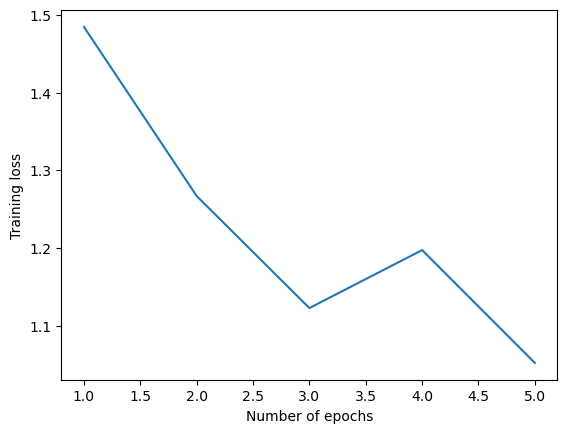

In [15]:
plt.plot(range(1, num_epochs + 1), train_loss_list)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.show()

In [16]:
model.eval()  # sett modellen i eval-modus
val_correct = 0
val_total = 0

with torch.no_grad():  # ingen gradienter under evaluering
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)                 # shape: (batch_size, num_classes)
        _, y_pred = torch.max(outputs, dim=1)   # predikert klasse per sample

        val_total += labels.size(0)             # legg til antall bilder i batchen
        val_correct += (y_pred == labels).sum().item()

val_acc = 100 * val_correct / val_total
print(f"Val set accuracy = {val_acc:.2f} %")


Val set accuracy = 70.99 %


In [19]:
import torch.optim as optim
from torch.utils.data import DataLoader
import itertools
import copy

class CNN(nn.Module):
    def __init__(
        self,
        num_classes: int = 5,
        conv_kernel_size: int = 3,
        conv_stride: int = 1,
        padding: int = 1,
        pool_kernel_size: int = 2,
        input_size=(1, 224, 224),
    ):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=conv_kernel_size,
                stride=conv_stride,
                padding=padding,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size),

            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=conv_kernel_size,
                stride=conv_stride,
                padding=padding,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_kernel_size),
        )

        # Finn flatten-dim automatisk
        with torch.no_grad():
            dummy = torch.zeros(1, *input_size)
            out = self.features(dummy)
            flatten_dim = out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_dim, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [20]:
def train_one_model(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=5,
    lr=1e-3,
    weight_decay=1e-4,
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.to(device)

    best_val_acc = 0.0
    best_state = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        # ---- TRAIN ----
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # ---- VALIDATION ----
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, preds = torch.max(outputs, dim=1)

                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_acc = 100 * val_correct / val_total

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    # returner beste val-accuracy og state_dict
    return best_val_acc, best_state


In [22]:
num_classes = 5
# Hyperparametere å søke over
padding_values        = [0, 1]
conv_stride_values    = [1, 2]           # stride kan ikke være 0
conv_kernel_values    = [3, 5]
pool_kernel_values    = [2, 3]
learning_rates        = [1e-3, 3e-4]
batch_sizes           = [16, 32]

search_space = list(itertools.product(
    padding_values,
    conv_stride_values,
    conv_kernel_values,
    pool_kernel_values,
    learning_rates,
    batch_sizes
))

best_config = None
best_val_acc = 0.0
best_model_state = None

input_size = (1, 224, 224)  # siden du bruker 224x224 grayscale
num_epochs = 5               # du kan endre dette

for (
    padding,
    conv_stride,
    conv_kernel,
    pool_kernel,
    lr,
    batch_size
) in search_space:

    print(
        f"\n=== Testing config: "
        f"padding={padding}, conv_stride={conv_stride}, "
        f"conv_kernel={conv_kernel}, pool_kernel={pool_kernel}, "
        f"lr={lr}, batch_size={batch_size} ==="
    )

    # Ny dataloader for denne batch-size
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    # Bygg modell
    try:
        model = CNN(
            num_classes=num_classes,
            conv_kernel_size=conv_kernel,
            conv_stride=conv_stride,
            padding=padding,
            pool_kernel_size=pool_kernel,
            input_size=input_size,
        )
    except RuntimeError as e:
        print("Config crashed (sannsynligvis pga for liten feature map):", e)
        continue

    val_acc, state = train_one_model(
        model,
        train_loader,
        val_loader,
        device,
        num_epochs=num_epochs,
        lr=lr,
        weight_decay=1e-4,   # kan du også tune hvis du vil
    )

    print(f"Validation accuracy for this config: {val_acc:.2f} %")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = {
            "padding": padding,
            "conv_stride": conv_stride,
            "conv_kernel": conv_kernel,
            "pool_kernel": pool_kernel,
            "lr": lr,
            "batch_size": batch_size,
        }
        best_model_state = state

print("\n=== GRID SEARCH DONE ===")
print(f"Best val accuracy: {best_val_acc:.2f} %")
print("Best config:", best_config)

# Hvis du vil bruke beste modell videre:
best_model = CNN(
    num_classes=num_classes,
    conv_kernel_size=best_config["conv_kernel"],
    conv_stride=best_config["conv_stride"],
    padding=best_config["padding"],
    pool_kernel_size=best_config["pool_kernel"],
    input_size=input_size,
)
best_model.load_state_dict(best_model_state)
best_model.to(device)
best_model.eval()



=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=2, lr=0.001, batch_size=16 ===


c:\Users\Anne-\anaconda3\envs\introML\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation accuracy for this config: 61.07 %

=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=2, lr=0.001, batch_size=32 ===
Validation accuracy for this config: 62.60 %

=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=2, lr=0.0003, batch_size=16 ===
Validation accuracy for this config: 73.28 %

=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=2, lr=0.0003, batch_size=32 ===
Validation accuracy for this config: 74.05 %

=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=3, lr=0.001, batch_size=16 ===
Validation accuracy for this config: 72.52 %

=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=3, lr=0.001, batch_size=32 ===
Validation accuracy for this config: 74.05 %

=== Testing config: padding=0, conv_stride=1, conv_kernel=3, pool_kernel=3, lr=0.0003, batch_size=16 ===
Validation accuracy for this config: 72.52 %

=== Testing config: padding=0, conv_stride=1, conv_

CNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5408, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)